In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import torch
from torch import Tensor
from torch import Tensor as T
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.optim
from torch.optim import SGD
import torch.nn.functional as F

# import keras
# L = keras.layers

import sys
sys.path.append('../code')

import deep_lvm_pose_tracking.toy_data as toy
from deep_lvm_pose_tracking.vae import VAE, loss_function, cVAE, fit
import deep_lvm_pose_tracking.vae as v

from sklearn import gaussian_process
from sklearn.decomposition import PCA

# from tqdm_utils import TqdmProgressCallback
from tqdm import tqdm_notebook as tqdm

from contextlib import ExitStack
from functools import partial

from IPython.core.debugger import set_trace

# from notebook_utils import *
import deep_lvm_pose_tracking.notebook_utils as nu

# import GPyOpt

# Some parameters:
N = 3600000  # number of observations
batch_size = 128
d = 64  # image edge length
D = d**2
img_shape = (d, d)
latent_dim = 4
print(f"{N} points with {D} dimensions.")

from functools import partial
plot_sample_grid = partial(nu.plot_sample_grid, img_shape=img_shape)

# don't forget to start visdom!
plotter = nu.VisdomLinePlotter(env_name='main')

# setting up torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

3600000 points with 4096 dimensions.
Pytorch: Train with cpu


# Toy data: Images of hierarchical structures without time dependency

Generate (64, 64)-pixel images from 7 parameters: 
- 3 angles for each image, 
- 3 bone lengths and keypoint marker width shared for whole dataset. 

Origin of the 3-bone hierarchy is the central pixel.
End of bones are marked by exponentiated quadratics.

In [3]:
# parameters:
eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32

pose_to_image = partial(nu.pose_to_image, bone_lengths=bone_lengths)

labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4),
              'pretrain': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4)
             }

# dataloader with size comparable of PCA's datasize limit
subsets = {k: Subset(h, np.random.choice(range(len(v)), size=5000)) for k, v in zip(['train', 'val'], [h, h_val])}
reduced_dataloader = {k: DataLoader(subsets[k], batch_size=batch_size, drop_last=True) for k in subsets}

# generate, encode, and decode new image for validation
idx = np.random.randint(0, len(h_val))
test_img = h_val[idx]['image']
test_angles = h_val[idx]['angles']

Bone lengths: [10.87406816  7.06382753 11.42064138]


### Example: See end of notebook for video!

How can we find the 3-dimensional generating manifold in $\mathbb{R}^{4096}$?

In [ ]:
h.plot_image(np.random.randint(0, len(labels)))

## PCA

A linear model is not enough to compress to 3 dimensions. Furthermore PCA is not able to handle the amount of data we want to use (e.g. 3.6M frames). Therefore we only use a subset. Only 145 of 4096 are needed to explain 0.95 of the variance. PCA will therefore be useful as preprocessing step.

In [ ]:
# Use subset of data because of memory restriction
idxs = np.random.choice(range(len(h)), replace=False, size=D)
imgs = np.array([h[i]['image'] for i in idxs])
X = np.reshape(imgs, (len(idxs), d**2))
pca = PCA().fit(X)
# n_comp = pca.n_components

vexpl = np.cumsum(pca.explained_variance_ratio_)
plt.plot(vexpl)
thresh = 0.95
n_comp = np.where(vexpl > thresh)[0][0]
plt.vlines(n_comp, 0, 1, linestyles='dotted')
plt.hlines(thresh, 0, 800, linestyles='dotted')
plt.title(f'{n_comp} components explain {thresh} of the variance')
plt.show()

Inspecting the first 9 PCs shows that PCA does some kind of circular Fourier decomposition. Not very interesting, but looks cool:

In [ ]:
# Plot first 9 components
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
ax[0, 1].set_title('First 9 principle components are fourier decomposition on a circle.')
for i in range(9):
    x, y = nu.to_ind[i]
    comp = pca.components_[i].reshape(img_shape)
    ax[x, y].imshow(comp)
# plt.tight_layout()
plt.show()

Reconstruction is satisfying enough:

In [ ]:
w = pca.transform(test_img.ravel()[None])[:, :n_comp]

recon_img = np.dot(w, pca.components_[:n_comp])[0].reshape(*img_shape)
recon_img = recon_img + pca.mean_.reshape(*img_shape)
nu.plot_reconstruction(recon_img, test_img)

In [ ]:
# dataloader = {'train': data_loader,
#               'val': val_loader}

loss = {}
loss_pp = {}
for phase in reduced_dataloader.keys():
    loss[phase] = []
    for data in tqdm(reduced_dataloader[phase]):
        original = data['image'].view(-1, D).cpu().detach().numpy()
        w = pca.transform(original)[:, :n_comp]
        recon_img = np.dot(w, pca.components_[:n_comp])
        loss[phase] += [(recon_img - original)**2]
    loss_pp[phase] = np.mean(np.array(loss[phase]))
    
for k in reduced_dataloader.keys():
    print(f'PCA {k} loss: {loss_pp[k]}')

Even though reconstruction is ok, we can not draw randomly from weights to generate images which remotely resemble our toy data:

In [ ]:
# generate image from noise
W = pca.transform(X)[:, :n_comp]

# Using uniform noise because it matches the
# statistics of w better than gaussian

min_w = W.min(axis=0)
span = W.max(axis=0) - min_w
print(np.mean(min_w), np.mean(span))

n_examples = 6
eps = np.random.rand(n_examples, n_comp)
w_rand = span[None] * eps + min_w[None]

generated = np.dot(w_rand, pca.components_[:n_comp])

fig, ax = plt.subplots(ncols=n_examples, sharey=True)
fig.set_size_inches(n_examples*3, 3)
ax[n_examples//2].set_title('Using weights sampled from \nuniform distribution to generate image.')
for i in range(n_examples): 
    ax[i].imshow(generated[i].reshape(*img_shape))
plt.show()

# Linear Autoencoder (PCA) and MLP Autoencoder

A linear autoencoder learns an approximation to PCA. Now we can leverage the power of deep learning frameworks (i.e. backpropagation on GPU and minibatching of data set). Results are the same as above. Now it's just adding layers and activation functions to get the standard autoencoder, which does not work at all:

In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self, code_size=10):
        nn.Module.__init__(self)
        self.encoder = nn.Linear(D, code_size)
        self.decoder = nn.Linear(code_size, D)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, h):
        return self.decoder(h)
    
    def forward(self, x):
        w = self.encode(x.view(-1, D))
        return self.decode(w)
    
class MLPAutoencoder(nn.Module):
    def __init__(self, code_size=10, hidden=40):
        nn.Module.__init__(self)
        self.encoder = nn.ModuleList([
            nn.Linear(D, hidden),
            nn.Linear(hidden, code_size),
            nn.Linear(D, code_size)
        ])
        self.decoder = nn.ModuleList([
            nn.Linear(code_size, hidden),
            nn.Linear(hidden, D),
            nn.Linear(code_size, D)
        ])
    
    def encode(self, x):
        # h = F.relu(self.encoder[0](x))
        # return F.relu(self.encoder[1](h))
        return F.relu(self.encoder[2](x))
    
    def decode(self, latent):
        #h = F.relu(self.decoder[0](latent))
        #return F.tanh(self.decoder[1](h))
        return F.tanh(self.decoder[2](latent))
    
    def forward(self, x):
        w = self.encode(x.view(-1, D))
        return self.decode(w)

In [ ]:
n_comp = 1000
la = LinearAutoencoder(code_size=n_comp)
la = MLPAutoencoder(code_size=n_comp)
la.to(device)

optimizer = torch.optim.Adam(la.parameters(), lr=1e-3)

train_losses = {}
for epoch in range(1):
    for phase in ['train', 'val']:
        train_losses[phase] = []
        with ExitStack() as stack:
            pbar = stack.enter_context(tqdm(dataloader[phase], leave=True))
            if phase == 'val':
                stack.enter_context(torch.no_grad())
                
            i = -1
            for batch in pbar:
                i += 1
                if i > 1000:
                    break
                data = batch['image'].float().to(device)
                recon = la(data.view(-1, D))
                l = torch.mean((recon - data.view(-1, D))**2)
                if phase == 'train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                train_losses[phase].append(l.cpu().detach().numpy())
                pbar.set_description(f'({phase}) Epoch {epoch}: MSE = {l:.5f}')
                
                if i % 20 == 0:
                    plotter.plot_image('recon', recon)
                    plotter.plot_image('orig', data)
        print(phase, np.mean(train_losses[phase]) if phase =='val' else train_losses[phase][-1])

# plt.plot(train_losses)
# plt.show()

In [ ]:
recon = la(Tensor(test_img).view(-1, D).to(device)).cpu().detach().numpy().reshape(img_shape)
nu.plot_reconstruction(recon, test_img)

## Deep Latent Variable Model a.k.a. Variational Autoencoder

We want to find the marginal likelihood of images $X$:

$p(X) = \int p(X|z)p(z) dz$.

If $p(X|z)$ is a density parameterized by $\eta = {NeuralNetwork}(z)$, we can not solve this integral analytically.
We can still sample from $z$ to estimate $p(X)$, but X is super-high-dimensional, $p(X|z)$ will be practically zero for all for most samples of $z$, if we don't sample in a smart manner.

Sampling $z$ from the posterior $p(z|X)$ would result in the most likely images, but we do not have the posterior.
Let's introduce an approximation $Q(z)$ to the posterior such that $\mathcal{KL}(Q(z)||P(z|X))$ is small:

\begin{align}
\mathcal{KL}[Q(z)||P(z|X)] &= \mathbb{E}[\log Q(z) - \log P(z|X)]\\
&= \mathbb{E}[\log Q(z) - \log P(X|z) - \log P(z)] + \log P(X)\\
&= \mathbb{E}[- \log P(X|z)] + \mathcal{KL}[Q(z)|| P(z)] + \log P(X)
\end{align}

\begin{align}
\Rightarrow\log P(X) - \mathcal{KL}[Q(z)||P(z|X)] &= \mathbb{E}[\log P(X|z)] - \mathcal{KL}[Q(z)|| P(z)]
\end{align}

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

### Bernoulli observation model

\begin{align}
\log P(X|z) = X\log(\text{NN}(z))+(1-X)\log(1-\text{NN}(z))
\end{align}

In [ ]:
# These parameters are not optimized yet
latent_dim = 3
hidden = 600
beta = 1

model = VAE(input_dim=D, latent_dim=latent_dim,
            hidden=hidden).to(device)

loss_func = partial(v.loss_function, likelihood='bernoulli')
val_loss = fit(model, dataloader, epochs=1, device=device, beta=beta, stop_crit=0, plotter=plotter)

The plots show $p(x|z)$ with $z \sim \mathcal{N}(0, 1)$.
Even though there is room for improvement (e.g. changing the output activation function), I think the network learned the hierarchical constraints.

In [ ]:
plot_sample_grid(nu.draw_samples(model))

### Traversing the latent space

Maybe the 3 latent dimensions correspond to the angles already?
$\rightarrow$ Not quite...

In [ ]:
mu_lat = np.zeros((1, latent_dim))
mu_np = mu_lat
model.to(device)
def get_img(ind):
    # mu_np = mu_lat.cpu().detach().numpy()
    fig, ax = plt.subplots()
    for x in np.linspace(-4, 4):
        mu_np[:, ind] = x
        mu_star = Tensor(mu_np).to(device)
        gen = model.decode(mu_star)[0]
        gen = gen.cpu().detach().numpy().reshape(img_shape)
        yield (x, gen)

fig, ax = plt.subplots()
img = h[0]['image']

mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(img):
    x, img = img
    ax.set_title(f'{x:.3}')
    mimg.set_data(img)
    return (mimg,)

In [ ]:
vids = []
for i in range(mu_lat.shape[1]):
    g = get_img(i)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=g, interval=120, 
                                   blit=True)
    vids += [anim.to_html5_video()]
    plt.close()

In [ ]:
HTML(vids[0])

In [ ]:
HTML(vids[1])

In [ ]:
HTML(vids[2])

## Gaussian observation model

\begin{align}
\log P(X|z) = -\frac{1}{2} \log(2\pi) - D\log(\text{NN}_\sigma(z)) - \frac{1}{2\text{NN}_\sigma(z)} (X-\text{NN}_\mu(z))^2
\end{align}

Two things are required to make Gaussian VAE work with toydata:

- PCA Trick: use weights of PCA as input
- use optimized weight $\beta$ for $\mathcal{KL}(q(z|x) || p(z))$ Term

In [ ]:
# following parameters have been found by GPyOpt for Gaussian VAE:
latent_dim = 8
hidden = 283
beta = 0.89
pca_dim = 525

continue_training = False
if continue_training:
    model.to(device)
else:
    model = VAE(input_dim=D, latent_dim=latent_dim, pre_dim=pca_dim,
                hidden=hidden, likelihood='normal').to(device)
    

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_func = partial(v.loss_function, beta=1, likelihood=model.likelihood)
loss_func = v.joint_loss

# model.to(device)
save_weights = False
weight_fn = 'gaussianVAEweights.pt' if save_weights else None

# N = 15000
dataloader = {'train': DataLoader(Subset(h, np.random.choice(range(len(h)), size=N)), num_workers=4,
                                 drop_last=True, batch_size=batch_size),
              'val': DataLoader(Subset(h_val, np.random.choice(range(len(h_val)), size=N//40)),
                               drop_last=True, batch_size=batch_size),
              'pretrain': DataLoader(Subset(h, np.random.choice(range(len(h_val)), size=N)),
                               drop_last=True, batch_size=batch_size)
             }
# reduced_dataloader['pretrain'] = DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
#                            drop_last=True, batch_size=batch_size)

val_loss = fit(model, dataloader, device=device,
                epochs=3, loss_func=v.joint_loss, weight_fn=weight_fn,
                plotter=plotter, stop_crit=0, beta=beta)

plot_sample_grid(nu.draw_samples(model))

In [ ]:
model.to('cpu')
test_input = test_img.ravel()[None]
img_param, latent_param, pose_param, pre_param = model(Tensor(test_input).to('cpu'), pose=None)
mu = img_param['mean'].cpu().detach().numpy().reshape(img_shape)
nu.plot_reconstruction(mu, test_img)

The Gaussian VAE results still don't seem as good. Maybe I should just stick to mixing Bernoulli and Gaussian observations for images and pose.

## Conditional VAE

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

\begin{align}
p(x | z, c), q(t | x, c)
\end{align}

## Generating poses given image

Estimating poses from images by training a shared latent variable model and then conditioning on the pose has some advantages:

- Errorbars: it's a probabilistic model
- Anomaly detection: $\mathcal{KL}(q(z|x)|\mathcal{N}(0, 1))$ will be large if input is very different than training samples

In [ ]:
latent_dim = 1 # one dimension is enough for this task!
weight_fn = None
beta = 1
cvae = cVAE(input_dim=3, condition_dim=D, latent_dim=latent_dim, hidden=600, likelihood='bernoulli',
           condition_on='image').to(device)

In [ ]:
loss_func = partial(v.joint_loss, likelihood='bernoulli')
hist = fit(cvae, dataloader, epochs=1, device=device, weight_fn=weight_fn,
           loss_func=loss_func,
           conditional=True, plotter=plotter, stop_crit=0, beta=beta)

In [ ]:
# draw random poses from validation set
idxs = np.random.choice(range(len(h_val)), size=9)
poses = np.array([h_val[i]['angles'] for i in idxs])
poses_degree = nu.un_normalize(poses)

# draw corresponding images from validation set
imgs = np.array([h_val[i]['image'] for i in idxs])
# generate poses from noise given images
samples = nu.draw_samples(cvae, imgs.reshape(9, D))

poses_recovered = nu.un_normalize(samples[:, D:])
np.std(poses_recovered-poses_degree, axis=0, ddof=1)

for i in range(9):
    label = samples[i, D:]
    pose_true = poses_degree[i]
    pose_recovered = nu.un_normalize(label)
    print('Ground truth:\n', pose_true)
    print('Pose recovered from image:\n', pose_recovered)
    print('Error:\n', pose_true-pose_recovered)
    fig, ax = plt.subplots(ncols=2, sharey=True)
    ax[0].set_title('pose (ground truth)')
    ax[0].imshow(pose_to_image(poses[i]))
    ax[1].set_title('pose|image')
    ax[1].imshow(pose_to_image(label))
    plt.show()

How does the one-dimensional latent space look like.

## Generating images given labels

It should be possible to generate images from noise conditioned on label. 
Even though conditioning removes some of the noise, it does not yet replicate
the label.

In [ ]:
save_weights = False
weight_fn = 'cvae_weights.pt' if save_weights else None
latent_dim = 3
beta = 0.89

save_weights = False
weight_fn = 'cvae_weights.pt' if save_weights else None

# torch.save(cvae.state_dict(), weight_fn)
# cvae.load_state_dict(torch.load(weight_fn))

cvae = cVAE(input_dim=D, latent_dim=latent_dim, pose_dim=3, hidden=600, likelihood='bernoulli').to(device)

loss_func = partial(v.joint_loss, likelihood='bernoulli')
hist = fit(cvae, dataloader, epochs=1, device=device, weight_fn=weight_fn,
           loss_func=loss_func,
           conditional=True, plotter=plotter, stop_crit=0, beta=beta)

In [ ]:
# plt.imshow(test_img)
idxs = np.random.choice(range(len(h_val)), size=9)
labels = np.array([h_val[i]['angles'] for i in idxs])
samples = nu.draw_samples(cvae, labels)
imgs = np.array([h_val[i]['image'] for i in idxs])
# labels, samples[:, D:]

In [ ]:
for i in range(9):
    label = samples[i, D:]
    img = samples[i, :D]
    fig, ax = plt.subplots(ncols=2, sharey=True)
    ax[0].set_title('label')
    ax[0].imshow(imgs[i])
    ax[1].set_title('img|label')
    ax[1].imshow(img.reshape(d, d))
    plt.show()

# Toy data: Adding time dependency

If the VAE works well enough on simple, unambiguous single frame toy data, a VAE with recurrent latent space should be able to tackle ambigous data.

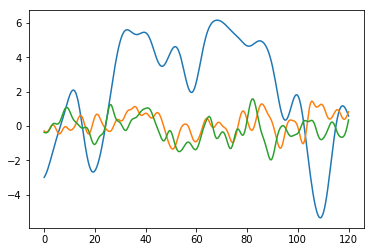

In [6]:
# introduce time dependency
rbf = gaussian_process.kernels.RBF(length_scale=2)
rbf_slow = gaussian_process.kernels.RBF(length_scale=5)
GP = gaussian_process.GaussianProcessRegressor(kernel=rbf)
GP_slow = gaussian_process.GaussianProcessRegressor(kernel=rbf_slow)

N = 250
t = np.linspace(0, 120, N)
y = np.empty((N, len(bone_lengths)))
y[:, 0] = GP_slow.sample_y(t[:, None], random_state=None)[:, 0]*3
for i in range(1, len(bone_lengths)):
    y[:, i] = GP.sample_y(t[:, None], random_state=None)[:, 0]*0.7
labels = y
plt.plot(t, labels)

# angles can not escape [-np.pi, np.pi]
idx = abs(y) > np.pi
y[idx] = y[idx] - 2*np.sign(y[idx])*np.pi

In [7]:
h = toy.HierarchyImages(labels, bone_lengths, key_marker_width=key_marker_width, img_shape=img_shape)
imgs = [h[i]['image'] for i in range(len(labels))]

In [11]:
fig, ax = plt.subplots()
img = imgs[0]
mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(i):
    img = imgs[i]
    mimg.set_data(img)
    return (mimg,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(imgs), interval=60, 
                               blit=True)
# anim.save(f'Toyproblem_unambiguous_{d}x{d}.mp4')
html_video = anim.to_html5_video()

In [12]:
# anim.to_html5_video()

In [13]:
HTML(html_video)

In [18]:
import json
with open('toy_data_video.html', 'w') as f:
    f.write(html_video)